# 缺失值处理
### 第一个方法：删除法

这里可以分为几种删除对象和不同的前提

* 首先是包含缺失值的样本的处理，在样本量比较大，且包含缺失值的样本数占的比例很小时，可以考虑删除包含有缺失值的样本。
* 变量删除，当某一个变量的缺失率较大的时候，而且这个变量不会影响到其他变量的时候，可以考虑。实际的情况可能就是由于某些方面也就是这个变量特征比较难以获取到因此才会造成大量缺失值的情况，像一些涉及隐私方面的信息。

### 第二种方法：填补法
删除数据会造成原始信息的遗失，为了避免这种情况，更多使用的是对缺失值进行填补。而填补的
方法也是有多种。适用于不同的情况下。填补的目的都是为了尽可能接近真实值来还原数据。
* 单一填补法

  使用均值、中位数、众数进行填补。在数值型的数据中，若存在的变量值呈现正态分布，采用均值进行填补；如果变量值呈现偏态，采用中位数填补；如果不属于数值型，可以采用众数填补。
* 多重填补法

  热卡填补法
  
  knn填补法
  
  回归填补法
  
  基于贝叶斯方法等

首先要先从数据中发现到缺失值的具体位置，可以使用pandas中的isnull()方法查找。返回结果是
只含有True和False的矩阵。接着只需要做一些处理就可以得出一些具体的缺失值的信息。

In [1]:
# 以房价预测中的数据为例
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
data_train = pd.read_csv("./train.csv")

# 使用sum统计每个变量的缺失值的数量
missvalues = data_train.isnull().sum() 

# 提取缺失值不为零的特征，soort_values()方法进行排序，参数ascending控制排序的方向（True由小到大，False相反）
missvalues[missvalues > 0].sort_values(ascending=False)  

C:\anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

可以看到一共也就1460个样本中，PoolQC这个变量就缺失了1453个，那么这就很符合变量删除的情况。但是通过查看数据说明可以了解到，缺失值原因是本身房子没有游泳池导致的，因此也就无法判定游泳池的质量。

放图

<img src = "游泳池.jpg" width=300>

因此这种应该是归为单独一种情况，我们给它填补为"None"。填补使用pd中的fillna方法，参数inplace选择是否直接修改原来样本。

In [2]:
data_train["PoolQC"].fillna("None", inplace=True)
data_train["PoolQC"].isnull().sum()  # 查看是否替换成功

0

于是按照一样的思路，经过查看，缺失值比例比较大的变量中绝大部分是属于这种情况，而且大多数
是离散型数据，许多都可以照这个方法填补上"None"。

至于填补均值，中位数，众数，还是可以使用fillna方法，只不过将None换成了我们要填补进去的对应的值。以其中的MasVnrArea：砖石饰面面积（平方英尺）为例。通过下面的图像可以了解到这个变量呈现偏态，因此我们可以填补为中位数，如果要均值的话，可以将median()替换成mean()；如果要众数的话可以将换成mode()[0]

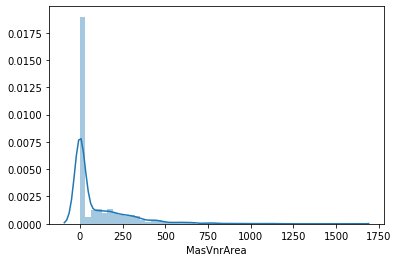

In [3]:
MasVnrArea = data_train['MasVnrArea'].dropna(inplace=False)  # 先去掉缺失值，不然无法作图
sns.distplot(MasVnrArea) 

In [4]:
data_train["MasVnrArea"].fillna(data_train["MasVnrArea"].median(), inplace=True)  # 填补中位数
data_train["MasVnrArea"].isnull().sum()

0

LotFrontage地块临街：连接到地产的街道的直线英尺

Neighborhood街道位置：埃姆斯市范围内的实际位置

LotArea地块面积：地块面积（平方英尺）

对于博客中对于变量LotFrontage缺失值的处理方法，看上去感觉是最近距离填补方法，通过与
LotFrontage相关的两个变量Neighborhood、LotArea分组来决定最近的样本，因此每一组中的样本
数量不一定相同。就是这个街道所在位置和它的地块面积来估计同一个街道范围的地块临街的缺失值
这样子解释就有点道理。

当然这里还用到了一些方法，例如groupby可以将数据依据选取的变量分组进行组内运算

还有pd.qcut方法将连续型数据切割成指定的份数

Dataframe.transform和lambda的结合运用，不过下面代码中lambda中的求中位数还是依据groupby
划分好后小组进行组内运算的，因此对于替换缺失值是依据与其所在小组内的中位数进行填补。
还有为什么要替换两次缺失值，因为依据两个变量进行分组会导致有些组没有相对应的值或者是有这个值但是这个值是缺失值，所以也是nan，因此填补进去还是nan。于是后面只依据一个变量进行分组
当然这些只是我自己的想法。

In [5]:
data_train.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        47.142857   43.0    14
Blueste        24.000000   24.0     2
BrDale         21.562500   21.0    16
BrkSide        57.509804   52.0    51
ClearCr        83.461538   80.0    13
CollgCr        71.682540   70.0   126
Crawfor        71.804878   74.0    41
Edwards        68.217391   65.5    92
Gilbert        79.877551   65.0    49
IDOTRR         62.500000   60.0    34
MeadowV        27.800000   21.0    15
Mitchel        70.083333   73.0    36
NAmes          76.462366   73.0   186
NPkVill        32.285714   24.0     7
NWAmes         81.288889   80.0    45
NoRidge        91.878788   91.0    33
NridgHt        81.881579   88.5    76
OldTown        62.788991   60.0   109
SWISU          58.913043   60.0    23
Sawyer         74.437500   71.0    48
SawyerW        71.500000   66.5    50
Somerst        64.666667   73.5    78
StoneBr        62.700000   61.5    20
Timber         80.133333   85.0    30
Veenker        59.714286   68.0     7

In [6]:
data_train["lotareaqcut"] = pd.qcut(data_train["LotArea"], 10)

In [7]:
data_train['LotFrontage']=data_train.groupby(['lotareaqcut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
data_train['LotFrontage']=data_train.groupby(['lotareaqcut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))